# Asteroid Astrometry Workbook

This workbook will guide you through measuring the precise RA and Dec coordinates (astrometry) of the asteroid 2013 GG69 on the night of June 19th, 2022. After making your measurements, you will input them into an orbit solver to visualize the orbit and find how frequently and closely the asteroid approaches Earth.

### Imports
We need a relatively large number of packages for this workbook. These packages include functions that will do most of the really hard work for us, including measuring star positions and performing astrometric solving. The next cell includes all imports.

In [ ]:
!pip install astroquery
!pip install photutils

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.time import Time
from datetime import datetime

from astroquery.astrometry_net import AstrometryNet

from photutils.aperture import CircularAperture
from photutils.centroids import centroid_2dg
from photutils.centroids import centroid_sources
from photutils.detection import DAOStarFinder

import matplotlib.pyplot as plt
from matplotlib import colors

from sow_tools import mask_bad_pix

The below cell is the base path where all the files for this project are located. Do not edit.

In [ ]:
store_path = 'raw/'

We need to get the names of all the files we will be using. Edit the list definitions below with correct file names and locations.
e.g. bias_files = ['file1.fits', 'file2.fits', etc...]. Find the correct files to use using the observing log from June 19th 2022, available as a .pdf in this assignment folder. https://jupyter1.idre.ucla.edu/services/phys180s22/files/phys180s22/source/Asteroid%20Astrometry/Observing%20Log.xlsx%20-%2020220619.pdf

In [ ]:
bias_files = ['d1022.fits', 'd1023.fits', 'd1024.fits', 'd1025.fits', 'd1026.fits', 'd1027.fits', 'd1028.fits', 'd1029.fits', 'd1030.fits']
flat_files = ['d1037.fits', 'd1038.fits', 'd1039.fits'] 
sci_files = ['d1065.fits', 'd1066.fits', 'd1067.fits', 'd1068.fits', 'd1069.fits', 'd1070.fits'] # science images that include asteroid

### Creating main calibrations
We want to average our individual calibration images together to make a main image that is more accurate than any of the individual images. To do this, we will read in the image data from each of our individual calibrations then take the median of every pixel value. It is better to take the median instead of a true average because the median is not changed by one large outlier, while an average is.

### Edit the code below to create a main bias image and save it in the main_bias variable
Reference the data reduction workbook or ask an instructor for help if you aren't sure what to do.

In [ ]:
bias_data = np.empty((9,1024,1056))
for i, file in enumerate(bias_files):
    hdu = fits.open(store_path+file)
    bias_data[i] = hdu[0].data
    hdu.close()

main_bias = np.nanmedian(bias_data,axis=0)

We will now plot the main bias to see what it looks like, no editing required.

In [ ]:
%matplotlib widget

med_bval = np.nanmedian(main_bias)

plt.figure(figsize=(10,10))
plt.imshow(main_bias, vmin=med_bval*0.98, vmax=med_bval*1.02, origin='lower')
plt.colorbar()
plt.title('main bias image', fontsize=20)
plt.show()

Now do the same but for the flat images. Save the image in the main_flat variable.
Remember that each individual flat image needs the main_bias subtracted from it before they are combined together.

In [ ]:
flat_data = np.empty((3,1024,1056))
for i, file in enumerate(flat_files):
    hdu = fits.open(store_path+file)
    bias_sub = (hdu[0].data - main_bias)
    
    flat_data[i] = bias_sub / np.nanmedian(bias_sub)
    hdu.close()

main_flat = np.nanmedian(flat_data, axis=0)

Once again we will plot the main flat to see what it looks like:

In [ ]:
%matplotlib widget

med_fval = np.nanmedian(main_flat)

plt.figure(figsize=(10,10))
plt.imshow(main_flat, vmin=med_fval*0.9, vmax=med_fval*1.1, origin='lower')
plt.colorbar()
plt.title('Main flat image', fontsize=20)
plt.show()

### Correcting our science images with the main calibrations
Here we will use our main bias and main flat images to correct all of the science images containing the asteroid. The science images are loaded for you, but you need to input the math for correcting it into the loop. 

In addition, we will use a function **mask_bad_pix** to remove bax pixels and cosmic rays from our science images. This function is already written, you simply need to give it the corrected image as the **sci_im** variable.
At the end of this cell, we save important information from the .fits header including the time that the observations occurred and where the telescope was roughly pointing in RA and Dec.

In [ ]:
num_sci = len(sci_files)
sci_data = np.empty((num_sci,1024,1024))
sci_coords = np.empty((num_sci,2))
time_data = []
for i, file in enumerate(sci_files):
    # loop through all science files
    hdu = fits.open(store_path+file)
    
    sci_im = (hdu[0].data - main_bias) / main_flat 
    
    # mask_bad_pix will search for significant outliers in our data and remove them, we also remove an unneeded overscan region of the images
    sci_data[i] = mask_bad_pix(sci_im)[0:1024,0:1024]
    
    # write the corrected science files into new .fits files that will be saved
    tmp = fits.PrimaryHDU(sci_data[i], header=hdu[0].header)
    tmpl = fits.HDUList(tmp)
    tmpl.writeto(store_path+file.strip('.fits')+'_calib.fits', overwrite=True)
    tmpl.close()
    
    # we also want to save some values from the .fits header that we need for astrometric measurements
    # grab the approximate RA and Dec pointing of the telescope
    sci_coords[i] = hdu[0].header['CRVAL2S'], hdu[0].header['CRVAL1S'] 
    # get the beginning and end time of each exposure
    time_data.append([Time(hdu[0].header['DATE-BEG'], format='isot', scale='utc'), Time(hdu[0].header['DATE-END'], format='isot', scale='utc')]) 
    
    # close and go to the next image
    hdu.close()

### Guessing star locations for an astrometric image solution
In the next few cells, we will work on providing astrometry.net the information it needs to give us an astrometric solution for each of our images. The most fundamental information that astrometry.net is the pixel positions of all the stars in the image. We could use a package to automatically identify all the stars, however, this can be somewhat difficult because if we accidentally identify some random noise as a star then it will be impossible be astrometry.net to find a solution since we've given it one or more stars that don't actually exist.

To be safer, we can manually identify the approximate pixel locations of sources we know are stars, then refine their positions with another package before giving them to astrometry.net.

In the next cell, we plot one of the science images. Below that, you need to edit the **prelim_sources** list to contain the positions of each star.

In [ ]:
%matplotlib widget

med_sval = np.nanmedian(sci_data[0])

plt.figure(figsize=(10,10))
plt.imshow(sci_data[0], vmin=med_sval*0.9, vmax=med_fval*10.5, origin='lower')
plt.colorbar()
plt.title('science image', fontsize=20)
plt.show()

Edit **prelim_sources** below. The format should a list of tuples:
prelim_sources = [(x1,y1), (x2,y2), ...]

In [ ]:
prelim_sources = [(634,121),(620,172),(748,29),(329,174),(73,194),(674,397),
                  (468,473),(299,377),(497,592),(980,450),(740,686),
                 (230,770),(803,808),(400,889),(397,542), (586,922),
                 (732,908),(867,928),(65,821),(93,504),(340,966)]#FIXME#FIXME#FIXME

prelim_sources = np.array(prelim_sources)

#### Telling astrometry.net our CCD scale
astrometry.net will find a solution much faster if we tell it the dimensions of our images and the rough pixel scale (what fraction of an arcsecond each pixel covers / arcseconds per pixel)

Find this information in the manual for the Nickel Direct Imaging Camera - https://mthamilton.ucolick.org/techdocs/instruments/nickel_direct/intro/

**Important -** all our images are taken with 2x pixel binning, which means the size of the detector is reduced by half and the pixel scale is doubled.

In [ ]:
image_width = 1024#FIXME
image_height = 1024#FIXME

plate_scale = 0.371#FIXME
scale_est = plate_scale

Using astrometry.net requires an API key associated to a registered account. This is provided below.

In [ ]:
api = 'svigftgopyhezcqs'
ast = AstrometryNet()
ast.api_key = api

### Refining sources and getting astrometric solutions!
Now we are ready to loop through our images and get an astrometric solution for each one. The next cell contains the loop.

At the beginning of the loop, we first use the centroid_sources function to precisely refine the pixel locations of stars we identified previously. For every image, we will go ahead and plot a red circle around the location of identified stars, that we can see if any stars are detected that shouldn't be.

Next, we will get the astrometric solution with the ast.solve_from_source_list() function. Here we pass it the star positions and the CCD parameters that we also found earlier. We also give it the rough RA and Dec pointing of the telescope so that astrometry.net doesn't have to search the entire sky for a matching pattern of stars. In general, astrometry.net can find solutions with very little information, but it goes much faster the more information we provide it.

ast.solve_from_source_list() returns the astrometry in a World Coordinate System (WCS) 'header' format, which we will put into a list for every image. These headers don't directly contain the astrometry for our asteroid, but contain all the information we need later. 

In [ ]:
wcs_list = []
    
for i, data in enumerate(sci_data):
    
    x, y = centroid_sources(data, prelim_sources[:,0], prelim_sources[:,1], box_size=21,
                        centroid_func=centroid_2dg)

    positions = np.transpose((x, y))
    apertures = CircularAperture(positions, r=4.0)
    plt.figure(figsize=(10,10))
    plt.imshow(data, origin='lower', vmin=0, vmax=30,
               interpolation='nearest')
    apertures.plot(color='red', lw=1.5, alpha=1.0)
    plt.colorbar()
    plt.show()
    
    wcs_header = ast.solve_from_source_list(x, y,
                                            image_width, image_height,
                                            solve_timeout=120, scale_units='arcsecperpix', scale_type='ev', scale_est=scale_est, scale_err=0.05,
                                            center_dec=sci_coords[i,0], center_ra=sci_coords[i,1], radius=1.0, parity=2)
    wcs_list.append(wcs_header)
    

The next cell is to check that all our astrometric solutions were successful. **If an error is returned, at least one solution was not successful** - get assistance from the instructor to identify what is going wrong before continuing.

In [ ]:
assert any(elem == {} for elem in wcs_list) == False

### Measuring the asteroid positions
We have an astrometric solution for our images, but we still need to measure the actual pixel positions of our asteroid to convert to RA and Dec with the solutions.

Below we will once again loop through our images and use the DAOStarFinder function to find the asteroid position. 

To make this easier, **set a range of x and y values in the image that will only contain the asteroid and no other sources**. The upper range and lower ranges correspond to the top and bottom pixel values that will bound the box containing our asteroid.

As before, we will plot a red circle on the identified source in each image. **Check that the circle is on the asteroid for every plot**.

In [ ]:
x_lower_range = 510 #FIXME
x_upper_range = 580 #FIXME
y_lower_range = 350 #FIXME
y_upper_range = 460 #FIXME

src_list = []

%matplotlib inline

for i, data in enumerate(sci_data):
    strip = data[y_lower_range:y_upper_range, x_lower_range:x_upper_range]
    mean, median, std = sigma_clipped_stats(strip, sigma=3.0)

    daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)  
    sources = daofind(strip - median) 
    src_list.append([sources['xcentroid'], sources['ycentroid']])
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.0)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(strip, origin='lower', norm=norm,
               interpolation='nearest')
    apertures.plot(color='red', lw=1.5, alpha=1.0)
    plt.show()

### Converting position to asteroid astrometry
Finally we will convert the asteroid pixel coordinates to RA and Dec coordinates using the astrometry solution.
In the box below, we measure the center pixel of the asteroid again in a small box, then feed it to the astrometry solution.

The function that transforms pixels to RA and Dec is **pixel_to_world**.

In [ ]:
bx_size = 10 # controls size of box around asteroid for centroiding
clist = []

for i, src in enumerate(src_list):
    # getting centroids
    cx, cy = int(src_list[i][0].value[0]) + x_lower_range, int(src_list[i][1].value[0] + y_lower_range)
    src_box = sci_data[i][cy-bx_size:cy+bx_size,cx-bx_size:cx+bx_size]
    bkgd = np.nanmedian(src_box)
    x,y = centroid_2dg(src_box - bkgd)
    
    px_x = x + bx_size + cx
    px_y = x + bx_size + cy
    
    w = WCS(wcs_list[i])
    coords = w.pixel_to_world(px_x, px_y)
    clist.append(coords)

### Formatting our astrometry for the Minor Planet Center
The International Astronomical Union (IAU) operates the Minor Planet Center (MPC) that coordinates worldwide observations of asteroids, comets and other minor bodies.

When reporting minor planet astrometry, the MPC requires a specific text format for the observations. We will produce one line of text for each image, and each line will specify the object being observed, when the observation was taken, the recorded astrometry in RA and Dec, and finally the location of the observation.

In [ ]:
# observation information
pck_no = 'K13G69G' # obj id for 2013 GG69 - the letter K specifies 2000
obs_code = '662' # observatory code for Lick observatory
note = ' C' # means obs was made with a CCD camera

for i, src in enumerate(src_list):
    
    # time stuff
    tstart = time_data[i][0]
    tend = time_data[i][1]
    tmid = ((tend-tstart)/2) + tstart
    day0 = Time(datetime(tstart.datetime.year, tstart.datetime.month, tstart.datetime.day),format='datetime')
    year = str(tmid.datetime.year)
    month = str(tmid.isot[5:7])
    day = tmid.isot[8:10] + str(np.round((tmid- day0).jd, 5))[1:] + ' '
    
    coords = clist[i]
    parr = [' ',pck_no,' ',note,year,month,day,
            str(int(coords.ra.hms[0])),str(int(coords.ra.hms[1])),str(np.round(coords.ra.hms[2],2)),
           '+'+str(int(coords.dec.dms[0])),str(int(coords.dec.dms[1])),str(np.round(coords.dec.dms[2],2)),obs_code,]
    print("{:5}{:6}{:1}{:2}{:5}{:3}{:9}{:3}{:3}{:5}{:4}{:3}{:27}{:3}".format(*parr))

### Visualizing an orbit based on our astrometry
Of course, our goal all along has been to figure out the orbit of the asteroid - astrometry was just the data we needed. To compute an orbit we will use an online solver called **Find_Orb**.

Go to https://www.projectpluto.com/fo.htm, then copy and paste your data from the lines above into the text box and hit **Compute orbit and ephemerides**. 

A new page of links and numbers will pop up. Most interesting is the button **Orbit Simulator View** where we can visualize the orbit of the asteroid along with the orbits of the planets of the solar system.

Below that, you will see a section titled **Orbital elements:**. Here we have the actual numbers for the orbital parameters.

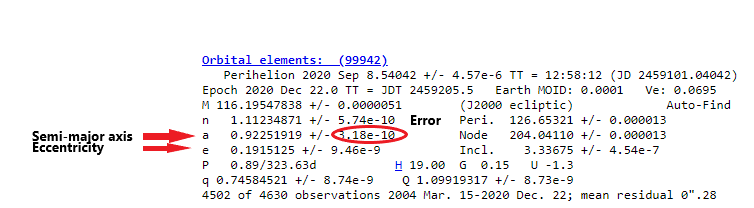

### Understanding orbital parameters
Among the orbital elements output, we are particularly interested in four parameters: semimajor axis (a), eccentricity (e), period (P), and inclination (Incl.). The do not describe the whole orbit, but they give the best picture of what it looks like.

Semimajor axis (a) describes the size of the orbit in space. Here we are given the semimajor axis in astronomical units (abbreviated au), where one astronomical unit corresponds to the semimajor axis of the Earth. For more reference, Jupiter has a semimajor axis of 5.2 au, and Venus has an semimajor axis of 0.72.

Eccentricity (e) describes how non-circular the orbit is. e=0 corresponds to a completely circular orbit, while larger values mean that the orbit is more and more elliptical. Elliptical orbits have an aphelion and perihelion, meaning a point farthest from the Sun and a point closest to the Sun. The more eccentric an orbit, the greater the difference between the distance from the Sun at aphelion and perihelion. You can calculate the aphelion as $$\text{aphelion}=a(1+e)$$ and perihelion as $$\text{perihelion}=a(1-e)$$

Period (P) is the time it takes to complete one orbit, given in years or days. The object returns to the same place after one period.

Finally, inclination (Incl.) is the angle between the orbital plane of the rest of the solar system and the orbital plane of the asteroid. An inclination of 0 corresponds to an orbit in the roughly the same plane as Earth, while an inclination of 90 degrees would be orbiting completely perpendicular to the direction that Earth orbits in.

### Analysis Questions
1. How close are the orbital parameters derived from our one night of astrometry to the "accepted" orbital parameters for this asteroid? You can find the MPC page for 2013 GG69 here - https://www.minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=2013+GG69
***
2. How does adding additional astrometry data from other sources improve the orbital solution? You can access the complete set of astrometry data for 2013 GG69 in the .txt file in this assignment (https://jupyter1.idre.ucla.edu/services/phys180s22/edit/phys180s22/source/Asteroid%20Astrometry/2013_GG69_mpc.txt). Try adding just one additional night of data, then a data point a week away. How do longer intervals between observations affect the derived orbit? How do the errors on the orbital parameters change as more astrometry data is added?
***
3. Based on the semimajor axis and eccentricity of the asteroid, calculate the aphelion and perihelion distance. Is 2013 GG69 an Earth-crossing asteroid? Based on the period, how frequently will 2013 GG69 cross Earth's orbit?